In [1]:
from time import process_time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import rebound
import reboundx
%matplotlib inline

In [2]:
Degree_To_Rad = np.pi/180.

m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]

a_p = 10 * R_Sun # semi-major axis of the planet

numerical simulation
--

In [3]:
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.G = 6.674e-11 # SI units
sim.dt = 1.e2 # Initial timestep in sec.
sim.N_active = 2 # Make it so dust particles don't interact with one another gravitationally

sim.add(m=m_Sun, hash="Star") # add Sun with mass in kg
sim.add(m=m_J, a=a_p, e=0, hash="Planet")
sim.move_to_hel() # move to heliocentric frame

ps = sim.particles

sim.status()

---------------------------------
REBOUND version:     	3.17.3
REBOUND built on:    	Jun 26 2021 14:35:07
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	100.000000
---------------------------------
<rebound.particle.Particle object at 0x7f93922b6dc0, m=1.99e+30 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x7f93922b6f40, m=1.898e+27 x=6957000000.0 y=0.0 z=0.0 vx=0.0 vy=138234.24576118717 vz=0.0>
---------------------------------


In [4]:
# set up reboundx and radiation force & PR-drag force

rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces")
rebx.add_force(rf)
rf.params["c"] = 3.e8

In [5]:
ps["Star"].params["radiation_source"] = 1 # set 'Star' to be the source of radiation

In [6]:
# Add multiple dust grains with the same orbit
sim.add(a=3*a_p, e=0, inc=0*Degree_To_Rad, hash="p1")
sim.add(a=3*a_p, e=0, inc=10*Degree_To_Rad, hash="p2")
sim.add(a=3*a_p, e=0, inc=20*Degree_To_Rad, hash="p3")
sim.add(a=3*a_p, e=0, inc=30*Degree_To_Rad, hash="p4")

sim.move_to_hel()
# sim.status()

In [7]:
ps["p1"].params["beta"] = 0.01
ps["p2"].params["beta"] = 0.01
ps["p3"].params["beta"] = 0.01
ps["p4"].params["beta"] = 0.01

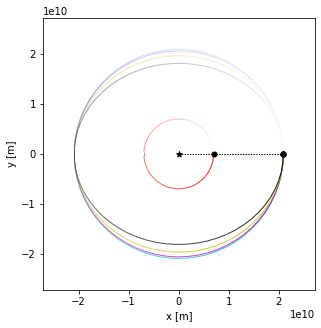

In [8]:
fig, ax = rebound.OrbitPlot(sim, unitlabel="[m]", color=True, periastron=True)

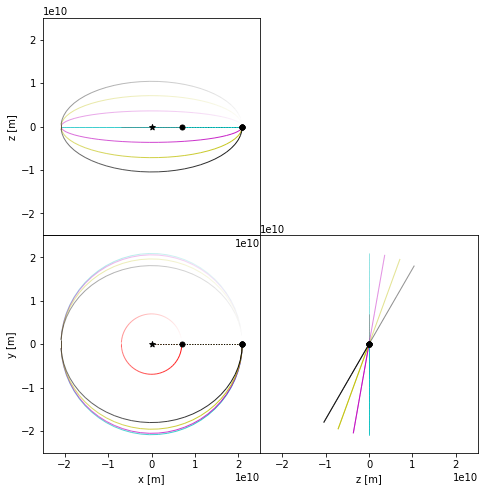

In [9]:
fig = rebound.OrbitPlot(sim, unitlabel="[m]", slices=1., color=True, periastron=True)

In [10]:
start = process_time()

yr = 365*24*3600 # s

Noutput = 1200
times = np.linspace(0, 2.5e3*yr, Noutput)

e1, a_d1, resonant_angle1 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e2, a_d2, resonant_angle2 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e3, a_d3, resonant_angle3 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e4, a_d4, resonant_angle4 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)

for i, time in enumerate(times):
    sim.integrate(time)
    e1[i], a_d1[i] = ps["p1"].calculate_orbit().e, ps["p1"].calculate_orbit().a
    e2[i], a_d2[i] = ps["p2"].calculate_orbit().e, ps["p2"].calculate_orbit().a
    e3[i], a_d3[i] = ps["p3"].calculate_orbit().e, ps["p3"].calculate_orbit().a
    e4[i], a_d4[i] = ps["p4"].calculate_orbit().e, ps["p4"].calculate_orbit().a
    resonant_angle1[i] = 2*ps["p1"].l -  ps['Planet'].l - ps['p1'].pomega
    resonant_angle2[i] = 2*ps["p2"].l -  ps['Planet'].l - ps['p2'].pomega
    resonant_angle3[i] = 2*ps["p3"].l -  ps['Planet'].l - ps['p3'].pomega
    resonant_angle4[i] = 2*ps["p4"].l -  ps['Planet'].l - ps['p4'].pomega
                                     
end = process_time()
print("Running time: %s Seconds"%(end-start))  

Running time: 228.469721 Seconds


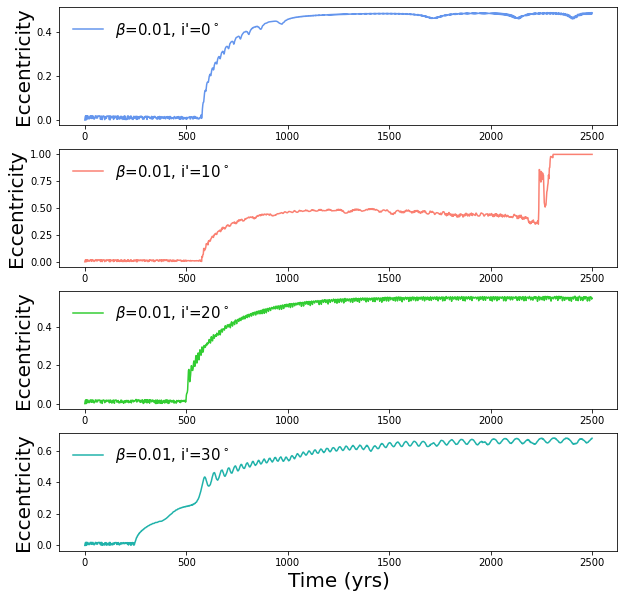

In [12]:
fig, ax = plt.subplots(4, 1, figsize=(10,10))

# ax[0].set_title(r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].set_ylabel('Eccentricity', fontsize=20)
ax[0].plot(times/yr, e1, color = 'cornflowerblue', label=r"$\beta$={}, i'=$0^\circ$".format(ps["p1"].params["beta"]))
ax[0].legend(frameon=False, loc='upper left', fontsize=15)

# ax[1].set_title(r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].set_ylabel('Eccentricity', fontsize=20)
ax[1].plot(times/yr, e2, color = 'salmon', label=r"$\beta$={}, i'=$10^\circ$".format(ps["p2"].params["beta"]))
ax[1].legend(frameon=False, loc='upper left', fontsize=15)

# ax[2].set_title(r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].set_ylabel('Eccentricity', fontsize=20)
# ax[2].set_xlim([1000, 1500])
ax[2].plot(times/yr, e3, color = 'limegreen', label=r"$\beta$={}, i'=$20^\circ$".format(ps["p3"].params["beta"]))
ax[2].legend(frameon=False, loc='upper left', fontsize=15)

# ax[3].set_title(r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].set_xlabel('Time (yrs)', fontsize=20)
ax[3].set_ylabel('Eccentricity', fontsize=20)
ax[3].plot(times/yr, e4, color = 'lightseagreen', label=r"$\beta$={}, i'=$30^\circ$".format(ps["p4"].params["beta"]))
ax[3].legend(frameon=False, loc='upper left', fontsize=15)

analytic
--

$(\frac{de'}{dt})_{trap} = \frac{GM_\odot\beta}{2^{\frac{7}{3}}a^2c}(\frac{(2+3e'^2)}{2e'(1-e'^2)^{\frac{3}{2}}} - \frac{5e'}{(1-{e'}^2)^{\frac{1}{2}}}) = \frac{GM_\odot}{2^{\frac{7}{3}}a^2c}\frac{\beta}{(1-\beta)^{\frac{2}{3}}}f(e')$



Integrate both side:
$\int_{0}^{e'(t)} \frac{1}{f(e')} \,de' = \int_{t_0}^{t} A\,dt$



Note that there is a criterion for test particle eccentricity:

$C_r(\alpha, e', s')\frac{(2+3e'^2)}{(1-e'^2)^{\frac{3}{2}}} \geq \frac{G^{\frac{1}{2}}{M_\odot}^{\frac{3}{2}}\beta(1-\beta)^{\frac{1}{2}}a}{4ma'^{\frac{3}{2}}c}$,

where $C_r(\alpha, e', s') = \{\frac{1}{2}\alpha e'(3+\alpha D){b_{\frac{1}{2}}^{(1)}(\alpha)} + \frac{1}{16}\alpha e'^3(-28 + 4\alpha D + 9\alpha^2D^2 + \alpha^3D^3){b_{\frac{1}{2}}^{(1)}(\alpha)} + \frac{1}{4}\alpha e's'^2(-4\alpha - \alpha^2 D)[{b_{\frac{3}{2}}^{(0)}(\alpha)} + {b_{\frac{3}{2}}^{(2)}(\alpha)}] + \frac{1}{\alpha}(-\frac{1}{2}e' + \frac{3}{8}e'^3 + \frac{1}{2}e's'^2)\}$

By rough estimation we are going to set the boundary condition for e' to be (0, 0.5).

In [15]:
G = 6.674e-11 # SI units
c = 3e8 # [m/s]
beta = ps["p1"].params["beta"]
A = G*m_Sun/(2**(7/3)*ps['Planet'].a*ps['Planet'].a*c) * beta/(1-beta)**(2/3)

In [68]:
from scipy.integrate import quad
def integrate(e_d):
    return 1/( (2+3*e_d*e_d)/(2*e_d*(1-e_d*e_d)**(3/2)) - 5*e_d/(1-e_d*e_d)**(1/2) )

e_d_array = np.linspace(1e-9, 0.5, 2000)

t_array = []
for e_d in e_d_array:
    t = quad(integrate, 1e-100, e_d) # e_d can't reach 0
    t_array.append(t[0]/A/yr+570) # migrate to resonance trapping starting time

In [69]:
# t_array1 = t_array

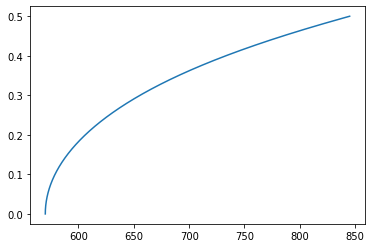

In [70]:
plt.plot(t_array, e_d_array)

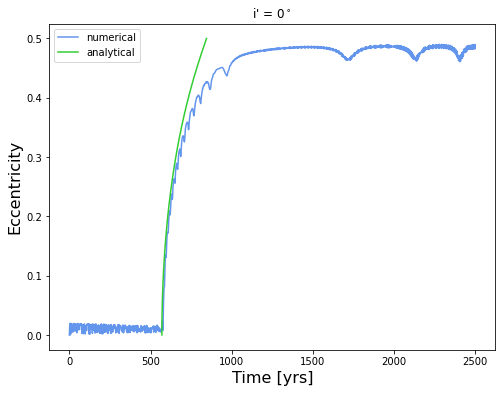

In [73]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.title(r"i' = $0^\circ$")
plt.xlabel("Time [yrs]", fontsize=16)
plt.ylabel("Eccentricity", fontsize=16)
plt.plot(times/yr, e1, color = 'cornflowerblue', label='numerical')
plt.plot(t_array, e_d_array, color = 'limegreen', label='analytical')
plt.legend()
# plt.savefig("./0.png", dpi=400)
plt.show()

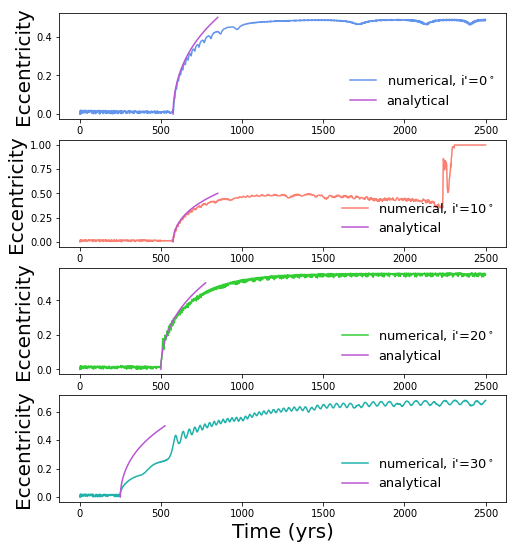

In [77]:
fig, ax = plt.subplots(4, 1, figsize=(8,9))

# ax[0].set_title(r"$\beta$={}".format(ps["p1"].params["beta"]))
ax[0].set_ylabel('Eccentricity', fontsize=20)
ax[0].plot(times/yr, e1, color = 'cornflowerblue', label=r"numerical, i'=$0^\circ$".format(ps["p1"].params["beta"]))
ax[0].plot(t_array1, e_d_array, color = 'mediumorchid', label='analytical')
ax[0].legend(frameon=False, loc='lower right', fontsize=13)

# ax[1].set_title(r"$\beta$={}".format(ps["p2"].params["beta"]))
ax[1].set_ylabel('Eccentricity', fontsize=20)
ax[1].plot(times/yr, e2, color = 'salmon', label=r"numerical, i'=$10^\circ$".format(ps["p2"].params["beta"]))
ax[1].plot(t_array2, e_d_array, color = 'mediumorchid', label='analytical')
ax[1].legend(frameon=False, loc='lower right', fontsize=13)

# ax[2].set_title(r"$\beta$={}".format(ps["p3"].params["beta"]))
ax[2].set_ylabel('Eccentricity', fontsize=20)
# ax[2].set_xlim([1000, 1500])
ax[2].plot(times/yr, e3, color = 'limegreen', label=r"numerical, i'=$20^\circ$".format(ps["p3"].params["beta"]))
ax[2].plot(t_array3, e_d_array, color = 'mediumorchid', label='analytical')
ax[2].legend(frameon=False, loc='lower right', fontsize=13)

# ax[3].set_title(r"$\beta$={}".format(ps["p4"].params["beta"]))
ax[3].set_xlabel('Time (yrs)', fontsize=20)
ax[3].set_ylabel('Eccentricity', fontsize=20)
ax[3].plot(times/yr, e4, color = 'lightseagreen', label=r"numerical, i'=$30^\circ$".format(ps["p4"].params["beta"]))
ax[3].plot(t_array4, e_d_array, color = 'mediumorchid', label='analytical')
ax[3].legend(frameon=False, loc='lower right', fontsize=13)

# plt.savefig("./1.png", dpi=400)

